# 심화과제 3: De-focusing Using Depth Map


<!-- - 3D NN의 output을 활용하는 예시 background 설명 추가 -->
<!-- - Depth estimation paper ref. 추가 -->
<!-- Depth map은 3차원 컴퓨터 그래픽스에서 관찰 시점으로부터 물체 표면과의 거리와 관련된 정보가 담긴 하나의 영상입니다.  -->
Depth map은 3차원 컴퓨터그래픽스 및 컴퓨터비전에서 관찰 시점으로부터 물체 표면과의 거리와 관련된 정보가 담긴 하나의 영상을 의미합니다. Depth map을 가지고 컴퓨터그래픽스 관점에서 다채로운 응용 사례에 활용될 수 있기 때문에, 컴퓨터비전에서는 Depth map estimation도 비중있는 문제로 여겨집니다.
<!-- Depth map을 바탕으로 2D 이미지에서는 얻을 수 없는 정보를 활용하여 다채로운 작업을 진행할 수 있습니다. -->

하나의 영상으로부터 Depth map을 추정하는 많은 뉴럴모델들이 개발 되어 왔습니다. 본 과제에서는 이러한 모델로부터 추론된 Depth map이 주어졌을 때, 어떻게 활용할 수 있는지 After re-focusing이라는 응용을 직접 구현해봅니다.

일반적으로 촬영된 영상은 포커스를 바꾸는 것이 불가능 합니다. After re-focusing은 depth map이라는 추가 정보를 활용하여, 이미 촬영된 영상에 대해서도, 사진 내에 특정 물체에 대해 focusing하고 배경은 de-focusing하는 기능을 의미 합니다. (아이폰의 '인물 사진' 모드를 생각하시면 좋습니다!)

<!-- 본 과제에서는 depth map을 이용하여 이미지 중에서 특정 물체에 대해 focusing하고 배경은 de-focusing하는 작업을 진행하고자 합니다. (아이폰의 '인물 사진' 모드를 생각하시면 좋습니다!) -->

**과제 목표**
- After re-focusing 기능에 대해서 원리를 파악한다.
- 유용한 Alpha blending 테크닉을 익힌다.
- 일부의 컴퓨터비전 모듈의 출력을 활용하여, 전체 응용 시스템을 구성해본다.
- 간단한 영상처리에 대한 구현을 숙달한다.

#### **참고 논문**

1. Eigen et al., Depth Map Prediction from a Single Image using a Multi-Scale Deep Network, NIPS 2014
<img src='https://feedforward.github.io/blog/assets/img/1112.png'  width="650">

2. Bian et al., Unsupervised Scale-consistent Depth and Ego-motion Learning from Monocular Video, NeurIPS 2019
<img src='https://d3i71xaburhd42.cloudfront.net/605fa5990fa23dac0066f97f9f5b41dfaba495ee/4-Figure1-1.png'  width="650">

In [1]:
# Seed
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
random.seed(0)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

##**Data Download**
해당 문제를 풀기 위해서는 2개의 image data가 필요합니다. 아래의 명령어를 통해 과제 해결에 필요한 파일들을 colab session에 다운로드하고 압축을 해제해주세요.

In [2]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1O5u-4AfcjnX2tyBF0T0b3AXCjUQ4Pwcg' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1O5u-4AfcjnX2tyBF0T0b3AXCjUQ4Pwcg" -O files.zip && rm -rf ~/cookies.txt

--2022-03-17 04:05:34--  https://docs.google.com/uc?export=download&confirm=&id=1O5u-4AfcjnX2tyBF0T0b3AXCjUQ4Pwcg
Resolving docs.google.com (docs.google.com)... 142.250.141.101, 142.250.141.139, 142.250.141.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-3g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qf1buquie8ufe5lc0uqob9ldcurt67sh/1647489900000/09977954582062536659/*/1O5u-4AfcjnX2tyBF0T0b3AXCjUQ4Pwcg?e=download [following]
--2022-03-17 04:05:36--  https://doc-0g-3g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qf1buquie8ufe5lc0uqob9ldcurt67sh/1647489900000/09977954582062536659/*/1O5u-4AfcjnX2tyBF0T0b3AXCjUQ4Pwcg?e=download
Resolving doc-0g-3g-docs.googleusercontent.com (doc-0g-3g-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to doc-0g-3g-docs.googleusercontent.com (doc-0

In [3]:
!unzip files.zip

Archive:  files.zip
  inflating: Louvre_ref.bmp          
  inflating: Louvre_Refined.bmp      


In [4]:
'''
과제 해결에 필요한 이미지를 불러옵니다.
- Louvre_ref.bmp: 과제 해결에 필요한 이미지입니다.
- Louvre_Refined.bmp: Louvre_ref에 대한 depth map 이미지입니다.
'''

original_image = cv2.imread('./Louvre_ref.bmp')
depth_map = cv2.imread('./Louvre_Refined.bmp')

In [5]:
def show_image(img, title=None):
  plt.figure(figsize=(10,5))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

  if title:
    plt.title(title, fontsize=14)

  plt.show()

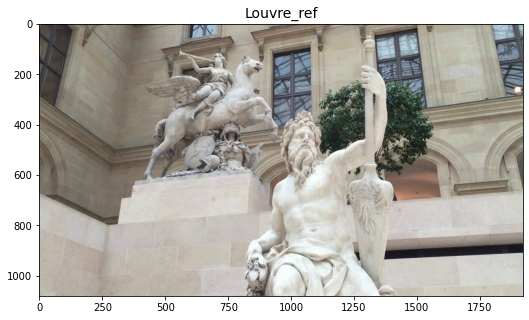

In [6]:
show_image(original_image, 'Louvre_ref')

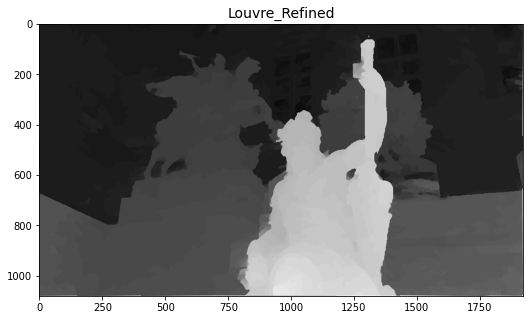

In [26]:
show_image(depth_map, 'Louvre_Refined')

**Depth map histogram**
- 아래는 주어진 depth map에 대한 histogram를 시각화하는 과정입니다. Depth map은 흑백 이미지(gray-scale)이므로 0~255 사이의 값들로 채워져있습니다. (0에 가까울 수록 어둡고 255에 가까울수록 밝습니다.)
- 위에서 확인한 depth map의 시각화 결과를 보면 depth를 기준으로 크게 3가지(맨 앞의 사람 동상, 가장 먼 배경 건물 그리고 그 사이에 있는 동상과 담벼락)로 구분 가능합니다.
- 각 영역을 사람의 눈이 아니라 이미지 값을 바탕으로 구분하기 위하여 히스토그램을 통해 각각의 부분을 구분짓는 경계값을 찾고자 합니다.
- 히스토그램 결과로도 크게 3개의 봉우리를 확인할 수 있으며 각 구간을 어림잡으면 [0, 50], [50, 150] 그리고 [150, 255]로 나눌 수 있습니다.

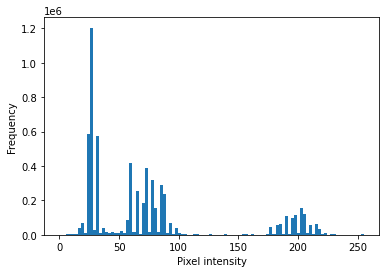

In [8]:
plt.hist(depth_map.reshape(-1), bins=100)
plt.ylabel('Frequency')
plt.xlabel('Pixel intensity')
plt.show()

# Focusing the object in front of the image

이미지 상에서 가장 앞에 있는 물체를 focusing하고자 합니다. 앞서 histogram을 통해 확인한 구간은 **[150, 255]**입니다. 따라서 해당 구간에 속하지 않는 나머지 영역은 blurring을 통하여 de-focusing하고자 합니다.

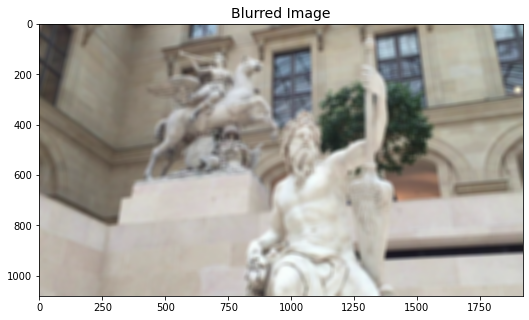

(1080, 1920, 3)


In [41]:
# 전체 이미지를 blurring하는 과정
blurred_image = cv2.blur(original_image, (20, 20))

show_image(blurred_image, 'Blurred Image')
print(blurred_image.shape)

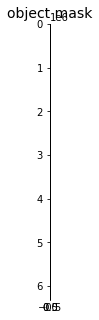

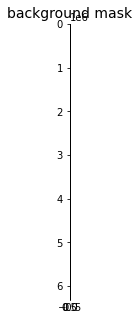

In [32]:
''' 
TO DO (1): Histogram을 통하여 확인한 구간 [150, 255]를 활용하여,
가장 앞에 있는 물체의 영역에는 1, 나머지 배경은 0을 갖는 binary mask를 만들어주세요.
'''
object_mask = np.array([1 if (150<=p<=255) else 0 for p in depth_map.reshape(-1)],dtype=np.uint8)
background_mask = np.invert(object_mask) - 254
show_image(object_mask, 'object mask')
show_image(background_mask, 'background mask')

In [33]:
''' 
TO DO (2): object_mask와 background_mask를 활용하여,
object 부분은 원본 이미지를 갖고 background 영역은 blur처리된 이미지를 갖는 defocused_image를 만들어주세요.
'''
defocused_image = (original_image * object_mask.reshape(1080, 1920, 3)) + (blurred_image * background_mask.reshape(1080, 1920, 3)) #(object_mask) + (background_mask)

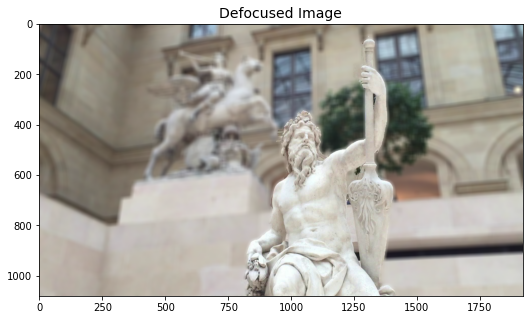

In [34]:
show_image(defocused_image, 'Defocused Image')

# Focusing the object in the middle of the image

이번에는 이미지 상에서 **거리상 중간에 위치한, 말을 타고 있는 사람 동상과 담벼락을 focusing**하고자 합니다. 앞서 histogram을 통해 확인한 구간은 **[50,150]**입니다. 마찬가지로 해당 구간에 속하지 않는 나머지 영역은 blurring을 통하여 de-focusing하고자 합니다.

In [56]:
''' 
TO DO (3): Histogram을 통하여 확인한 구간 [50, 150]를 활용하여,
가운데에 위치한 물체(말을 타고 있는 사람 동상과 담려박)의 영역에는 1, 나머지 배경은 0을 갖는 binary mask를 만들어주세요.
'''
object_mask = np.array([1 if 50<=p<=150 else 0 for p in depth_map.reshape(-1)], dtype=np.uint8)
background_mask = np.invert(object_mask) - 254
#for p in depth_map.reshape(-1):
#  print(type(p))
#show_image(object_mask, 'obj')
#show_image(background_mask, 'backg')

In [64]:
''' 
NOTE: 앞선 TO DO (2)와 동일한 코드를 사용해주세요!

TO DO (4): object_mask와 background_mask를 활용하여,
object 부분은 원본 이미지를 갖고 background 영역은 blur처리된 이미지를 갖는 defocused_image를 만들어주세요.
'''
#show_image(original_image, 'original')
#show_image(object_mask.reshape(1080,1920,3), 'obj')
#show_image(original_image * object_mask.reshape(1080, 1920, 3), 'result')
#show_image(background_mask.reshape(1080,1920,3), 'backg')
#show_image(blurred_image * background_mask.reshape(1080, 1920, 3), 'result2')

defocused_image = (original_image * object_mask.reshape(1080, 1920, 3)) + (blurred_image * background_mask.reshape(1080, 1920, 3))

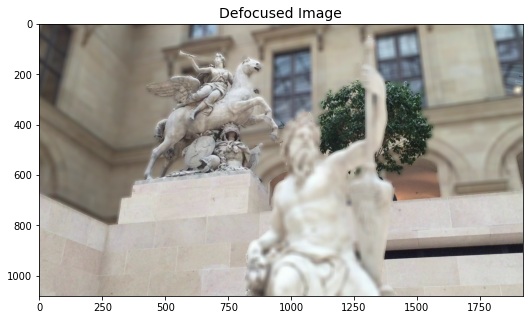

In [65]:
show_image(defocused_image, 'Defocused Image')

# Alpha-blending

- 지금까지 만든 focusing 이미지는 단순히 각 영역에 대해 원본 이미지의 값을 사용할지 혹은 blur처리된 값을 사용할지 양자택일한 결과이기 때문에 focusing의 강도를 조절할 수 없습니다.
- 따라서 0~1 사이의 alpha값을 이용하여 focusing 강조를 조절하고자 합니다. (1에 가까울 수록 원하는 물체가 더욱 강하게 focusing 되는 효과)
- 총 4개의 alpha값들(0.2, 0.4, 0.6, 0.8)에 대해 점점 값이 커질 수록 물체의 가장 앞에 있는 동상에 대한 focusing이 강해지도록 코드를 완성해주세요.

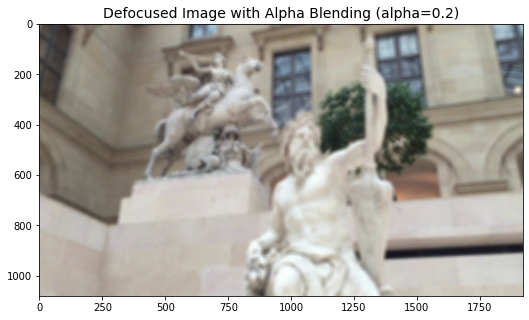

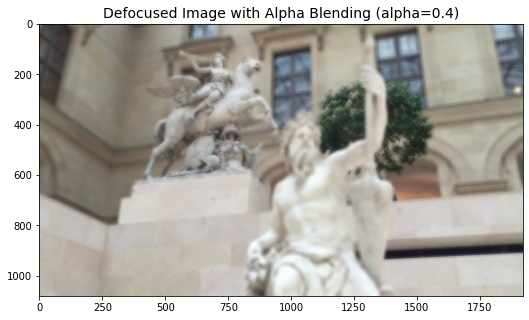

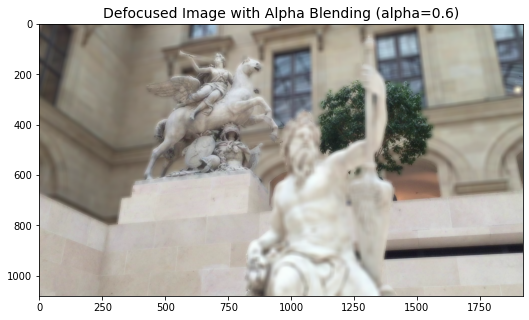

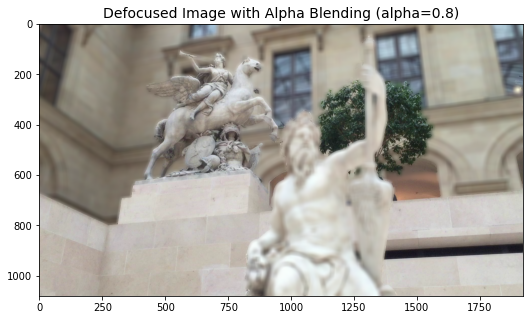

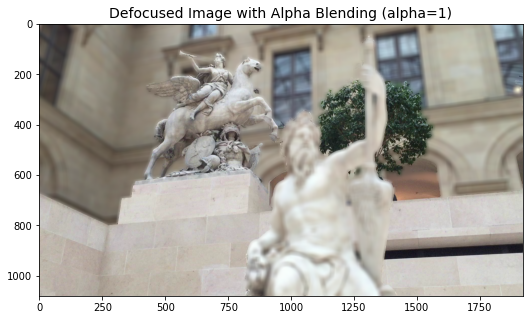

In [73]:
for alpha in [0.2, 0.4, 0.6, 0.8, 1]:
  ''' 
  TO DO (5): Histogram을 통하여 확인한 구간 [50, 150]를 활용하여,
  가장 앞에 있는 물체의 영역에는 alpha값, 나머지 배경은 0을 갖는 object_mask_w_alpha를 만들어주세요.
  '''
  object_mask_w_alpha = np.array([alpha if 50<=p<=150 else 0 for p in depth_map.reshape(-1)],dtype=np.float_)
  background_mask_w_alpha = (1-object_mask_w_alpha)

  defocused_image_w_alpha = (original_image * object_mask_w_alpha.reshape(1080,1920,3)) + (blurred_image * background_mask_w_alpha.reshape(1080,1920,3))
  defocused_image_w_alpha = defocused_image_w_alpha.astype(np.uint8)

  show_image(defocused_image_w_alpha, 'Defocused Image with Alpha Blending (alpha=%s)' % alpha)